# Numba

In [1]:
import numpy as np

<img src="https://cdn.dribbble.com/users/915978/screenshots/3034118/numba_1x.jpg" alt="Drawing" style="width: 40%;"/>



- Numba is a compiler for Python array and numerical functions.
- Numba generates optimized machine code from pure Python code with a few simple annotations
- Python code is just-in-time optimized to performance similar as C, C++ and Fortran, without having to switch languages or Python interpreters.
- The code is generated on-the-fly for CPU (default) or GPU hardware.

## Python decorator

A decorator is used to modify a function or a class. A reference to a function "func" or a class "C" is passed to a decorator and the decorator returns a modified function or class. The modified functions or classes usually contain calls to the original function "func" or class "C". 

In [2]:
def timeit(function):
    def wrapper(*args, **kargs):
        import time
        t1 = time.time()
        result = function(*args, **kargs)
        t2 = time.time()
        print("execution time", t2-t1)
        return result
    return wrapper

@timeit
def f(a, b):
    return a + b

print(f(1, 2))

execution time 9.5367431640625e-07
3


## First example

In [3]:
from numba import jit
@jit
def sum(a, b):
    return a + b

- Compilation will be deferred until the first function execution. 
- Numba will infer the argument types at call time.

In [4]:
sum(1, 2), sum(1j, 2)

(3, (2+1j))

In [5]:
x = np.random.rand(10)
y = np.random.rand(10)
sum(x, y)

array([1.22560897, 1.07968528, 0.09849369, 0.96158978, 1.19473834,
       0.79349524, 0.59270553, 1.10775344, 1.59163481, 0.29680208])

## Performance

In [6]:
x = np.random.rand(10000000)

In [7]:
%timeit x.sum() # Numpy

7.71 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
@jit
def numba_sum(x):
    res= 0
    for i in range(x.size):
        res += x[i]
    return res

In [9]:
%timeit numba_sum(x)

11.1 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numba methods

In [10]:
@jit
def jit_sum(a, b):
    return a + b

In [11]:
jit_sum.inspect_types() # jit_sum has not been compiled

In [12]:
jit_sum(1, 2) # call it once with ints
jit_sum.inspect_types()

jit_sum (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-10-ebda2b2f7dda>
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def jit_sum(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $6binary_add.2 = a + b  :: int64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: int64
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b




In [13]:
jit_sum(1., 2.) # call it once with doubles
jit_sum.inspect_types()

jit_sum (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-10-ebda2b2f7dda>
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def jit_sum(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $6binary_add.2 = a + b  :: int64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: int64
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b


jit_sum (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-10-ebda2b2f7dda>
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def jit_sum(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: float64
    #   b = arg(1, name=b)  :: float64
    #   $6binary_add.2 = a + b  :: float64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: float64
    #  

- `jit_sum.inspect_llvm()` returns a dict with llvm representation.

LLVM is a library that is used to construct, optimize and produce intermediate and/or binary machine code.

- `jit_sum.inspect_asm()` returns a dict with assembler information. 

In [14]:
jit_sum.py_func(1, 2) # call origin python function without numba process

3

## Types coercion

Tell Numba the function signature you are expecting.

In [15]:
@jit(['int32[:](int32[:], int32[:])','int32(int32, int32)'])
def product(a, b):
    return a*b

In [16]:
product(2, 3), product(2.2, 3.2)

(6, 6)

In [17]:
a = np.arange(10, dtype=np.int32)
b = np.arange(10, dtype=np.int32)
product(a, b)

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81], dtype=int32)

In [18]:
a = np.random.random(10) # Numpy arrays contain double by default
b = np.random.random(10)
try:
    product(a, b)
except TypeError as e:
    print("TypeError:",e)

TypeError: No matching definition for argument type(s) array(float64, 1d, C), array(float64, 1d, C)


## Numba types
```C
void,
intp, uintp,
intc, uintc,
int8, uint8, int16, uint16, int32, uint32, int64, uint64,
float32, float64,
complex64, complex128.
```
### Arrays
```C
float32[:] 
float64[:, :]
```

## Numba compilation options

- ** nopython ** : Compilation fails if you use pure Python objects.
- ** nogil ** : release Python’s global interpreter lock (GIL).
- ** cache ** : Do not recompile the function each time you invoke a Python program.
- ** parallel ** : experimental feature that automatically parallelizes must be used in conjunction with nopython=True:



## Inlining

Numba-compiled functions can call other compiled functions. The function calls may even be inlined in the native code, depending on optimizer heuristics.

In [19]:
import math
from numba import njit

@njit
def square(x):
    return x ** 2

@njit
def hypot(x, y):
    return math.sqrt(square(x) + square(y)) # square function is inlined

In [20]:
hypot(2., 3.)

3.605551275463989

## @vectorize decorator

- Numba’s vectorize allows Python functions taking scalar input arguments to be used as NumPy ufuncs. 
- Write your function as operating over input scalars, rather than arrays. Numba will generate the surrounding loop (or kernel) allowing efficient iteration over the actual inputs.

### Two modes of operation:

1. Eager mode: If you pass one or more type signatures to the decorator, you will be building a Numpy universal function (ufunc). 
2. Call-time mode: When not given any signatures, the decorator will give you a Numba dynamic universal function (DUFunc) that dynamically compiles a new kernel when called with a previously unsupported input type. 



In [21]:
from numba import vectorize, float64, float32, int32, int64

@vectorize([float64(float64, float64)])
def f(x, y):
    return x + y

If you pass several signatures, beware that you have to pass most specific signatures before least specific ones (e.g., single-precision floats before double-precision floats)

In [22]:
@vectorize([int32(int32, int32),
            int64(int64, int64),
            float32(float32, float32),
            float64(float64, float64)])
def f(x, y):
    return x + y

In [23]:
a = np.arange(6)
f(a, a)

array([ 0,  2,  4,  6,  8, 10])

In [24]:
a = np.linspace(0, 1, 6)
f(a, a)

array([0. , 0.4, 0.8, 1.2, 1.6, 2. ])

In [25]:
a = np.linspace(0, 1+1j, 6)
f(a, a)

TypeError: ufunc 'f' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Why not using a simple iteration loop using the @jit decorator? 

The answer is that NumPy ufuncs automatically get other features such as reduction, accumulation or broadcasting.

In [26]:
a = np.arange(12).reshape(3, 4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [27]:
f.reduce(a, axis=0)

array([12, 15, 18, 21])

In [28]:
f.reduce(a, axis=1)

array([ 6, 22, 38])

In [29]:
f.accumulate(a)

array([[ 0,  1,  2,  3],
       [ 4,  6,  8, 10],
       [12, 15, 18, 21]])

In [30]:
f.accumulate(a, axis=1)

array([[ 0,  1,  3,  6],
       [ 4,  9, 15, 22],
       [ 8, 17, 27, 38]])

## The vectorize() decorator supports multiple ufunc targets:

- **cpu**  *Single-threaded CPU* : small data sizes (approx. less than 1KB), no overhead.
- **parallel** *Multi-core CPU* : medium data sizes (approx. less than 1MB), small overhead.
- **cuda**  *CUDA GPU* big data sizes (approx. greater than 1MB), significant overhead.



## The @guvectorize decorator

- It allows you to write ufuncs that will work on an arbitrary number of elements of input arrays, and take and return arrays of differing dimensions.

In [31]:
from numba import guvectorize
@guvectorize([(int64[:], int64[:], int64[:])], '(n),()->(n)')
def g(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y[0]  # adds the scalar y to all elements of x

This decorator has two arguments:
- the declaration (n),()->(n) tells NumPy that the function takes a n-element one-dimension array, a scalar (symbolically denoted by the empty tuple ()) and returns a n-element one-dimension array;
- the list of supported concrete signatures as in @vectorize; here we only support int64 arrays.

## Automatic parallelization with @jit

- Setting the parallel option for jit() enables this experimental Numba feature.
- **Array Expressions like  element-wise or point-wise array operations are supported.**
    - unary operators: + - ~
    - binary operators: + - * / /? % | >> ^ << & ** //
    - comparison operators: == != < <= > >=
    - Numpy ufuncs that are supported in nopython mode.
    - Numpy reduction functions sum and prod.

- Numpy array creation functions zeros, ones, and several random functions (rand, randn, ranf, random_sample, sample, random, standard_normal, chisquare, weibull, power, geometric, exponential, poisson, rayleigh, normal, uniform, beta, binomial, f, gamma, lognormal, laplace, randint, triangular).

Numpy dot function between a matrix and a vector, or two vectors. In all other cases, Numba’s default implementation is used.

Multi-dimensional arrays are also supported for the above operations when operands have matching dimension and size. The full semantics of Numpy broadcast between arrays with mixed dimensionality or size is not supported, nor is the reduction across a selected dimension.

http://numba.pydata.org/numba-doc/latest/user/parallel.html

## Explicit Parallel Loops

Another experimental feature of this module is support for explicit parallel loops. One can use Numba’s prange instead of range to specify that a loop can be parallelized. The user is required to make sure that the loop does not have cross iteration dependencies except the supported reductions. Currently, reductions on scalar values are supported and are inferred from in-place operations. The example below demonstrates a parallel loop with a reduction (A is a one-dimensional Numpy array):

In [32]:
from numba import njit, prange
@njit(parallel=True)
def prange_test(A):
    s = 0
    for i in prange(A.shape[0]):
        s += A[i]
    return s

## Exercise 
- Optimize the Laplace equation solver with numba.
    1. Use only @jit 
    2. Try to use @jit(nopython=True) option
    3. Optimize the laplace function with the right signature.
    4. Try to parallelize.

(2457, 9.997295133247811e-06)
 iterations =  2457


CPU times: user 28.2 s, sys: 446 ms, total: 28.7 s
Wall time: 28.3 s


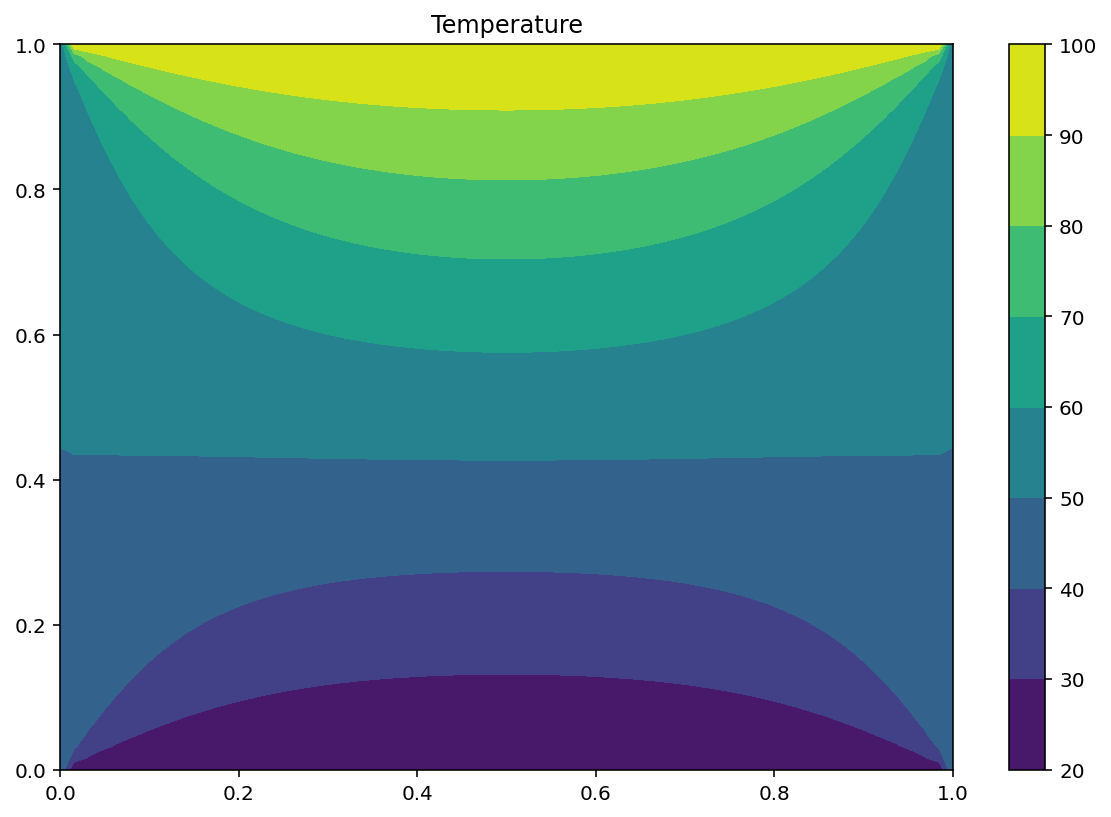

In [33]:
%%time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import itertools
from numba import jit, float64
# Boundary conditions
Tnorth, Tsouth, Twest, Teast = 100, 20, 50, 50

# Set meshgrid
n, l = 64, 1.0
X, Y = np.meshgrid(np.linspace(0,l,n), np.linspace(0,l,n))
T = np.zeros((n,n))

# Set Boundary condition
T[n-1:, :] = Tnorth
T[:1, :] = Tsouth
T[:, n-1:] = Teast
T[:, :1] = Twest

def laplace(T, n):
    residual = 0.0
    for i in range(1, n-1):
        for j in range(1, n-1):
            T_old = T[i,j]
            T[i, j] = 0.25 * (T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1])
            if T[i,j]>0:
                residual=max(residual,abs((T_old-T[i,j])/T[i,j]))
    return residual

residual = 1.0   
istep = 0
while residual > 1e-5 :
    istep += 1
    residual = laplace(T, n)
    print ((istep, residual), end="\r")

print("\n iterations = ",istep)
plt.rcParams['figure.figsize'] = (10,6.67)
plt.title("Temperature")
plt.contourf(X, Y, T)
plt.colorbar()

## Vectorize performance

In [34]:
import socket
import numpy as np
from numba import vectorize

@vectorize(['float64(float64, float64)'], target="cpu", cache=True, nopython=True)
def cpu_add(a, b):
   return a + b

@vectorize(['float64(float64, float64)'], target="parallel", cache=True, nopython=True)
def parallel_add(a, b):
   return a + b

if socket.gethostname() == "gpu-irmar.insa-rennes.fr":
    @vectorize(['float64(float64, float64)'], target="cuda", cache=True, nopython=True)
    def parallel_add(a, b):
       return a + b

/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

 16% (1 of 6) |####                      | Elapsed Time: 0:00:28 ETA:   0:02:20

 33% (2 of 6) |########                  | Elapsed Time: 0:00:37 ETA:   0:00:36

 50% (3 of 6) |#############             | Elapsed Time: 0:00:54 ETA:   0:00:53

 66% (4 of 6) |#################         | Elapsed Time: 0:01:10 ETA:   0:00:31

 83% (5 of 6) |#####################     | Elapsed Time: 0:01:40 ETA:   0:00:29

100% (6 of 6) |##########################| Elapsed Time: 0:02:04 Time:  0:02:04

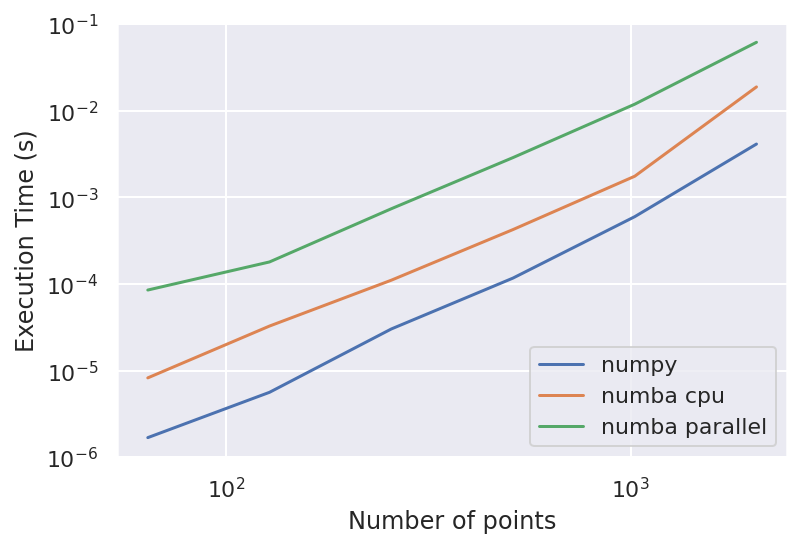

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import progressbar
Nrange = (2 ** np.arange(6, 12)).astype(int)

t_numpy = []
t_numba_cpu = []
t_numba_parallel = []

bar = progressbar.ProgressBar()

for N in bar(Nrange):
    # Initialize arrays

    A = np.ones(N*N, dtype=np.float32).reshape(N,N)
    B = np.ones(A.shape, dtype=A.dtype)
    C = np.empty_like(A, dtype=A.dtype)

    t1 = %timeit -oq C = A + B
    t2 = %timeit -oq C = cpu_add(A, B)
    t3 = %timeit -oq C = parallel_add(A, B)
        
    t_numpy.append(t1.best)
    t_numba_cpu.append(t2.best)
    t_numba_parallel.append(t3.best)
   
plt.loglog(Nrange, t_numpy, label='numpy')
plt.loglog(Nrange, t_numba_cpu, label='numba cpu')
plt.loglog(Nrange, t_numba_parallel, label='numba parallel')
plt.legend(loc='lower right')
plt.xlabel('Number of points')
plt.ylabel('Execution Time (s)');

# References

* [Numba by Loic Gouarin](https://github.com/gouarin/cours_numba_2017)
* [Numba Documentation](http://numba.pydata.org/numba-doc/latest/index.html)
* [Numbapro](https://github.com/ContinuumIO/numbapro-examples/)
* [Numba examples](https://github.com/harrism/numba_examples)
